In [14]:
import pypulse as pulsar
import matplotlib.pyplot as plt
import numpy as np
import glob
import subprocess
from IPython.display import Image

In [15]:
# Load all PFD files in folder
#ant = 'A2'                                               # antena usada (A1 o A2)
#timing_folder = './' + str(ant) + '/'
#pfd_files = glob.glob(timing_folder+'*pfd')

timing_folder = ''
pfd_files = glob.glob(timing_folder+'*sm')
print(pfd_files)

['template_1024_A2.std.sm']


In [16]:
# Convert PFD files to PSRFITS
for pfd in pfd_files:
    subprocess.check_call(['psrconv','-o','PSRFITS','-e','fits',pfd])

# Save all PSRFITS files
psrfits_files = glob.glob(timing_folder+'*fits')

# Load all PSRFITS into PyPulse
fits_pypulse= []
for psrfits in psrfits_files:
    temp_pypulse= pulsar.Archive(psrfits)
    fits_pypulse.append(temp_pypulse)

observations = dict(zip(psrfits_files, fits_pypulse))

Loading: template_1024_A2.std.fits
Load time: 0.82 s


In [17]:
# Create single pulse object
# Creat array of best profiles

single_pulses=[]

for observation in fits_pypulse:
    
    # First crunch in time and frequency
    observation.fscrunch()
    observation.tscrunch()
    
    # Now get array of the best profile
    tmp_singlepulse = observation.getSinglePulses(windowsize=256)
    
    # Align and normalize
    tmp_singlepulse.center_align()
    tmp_singlepulse.normalize()
    
    # Save aligned and normalize in each observation
    single_pulses.append(tmp_singlepulse)
    
# Save single pulse object
sp_observations = dict(zip(psrfits_files, single_pulses))

In [21]:
print(sp_observations)

for key in observations:
    sn = sp_observations[key].getSN()
    print(sn)
    print(key)
    file = key.replace(".fits","")
    print(file)

{'template_1024_A2.std.fits': <pypulse.singlepulse.SinglePulse object at 0x7f9023e72908>}
311.308781973
template_1024_A2.std.fits
template_1024_A2.std


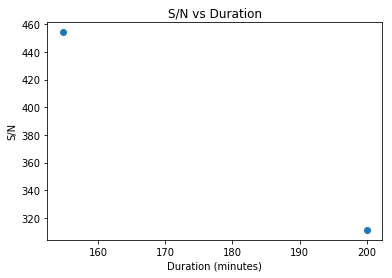

In [19]:
# Plot SN vs duration

duration=[]

allsn = []

for key in observations:
    time = (observations[key].getDuration())/60
    sn = sp_observations[key].getSN()
    bins = observations[key].getNbin()
    duration.append(time)
    allsn.append(sn)
    
plt.close()
plt.scatter(duration, allsn)
plt.title('S/N vs Duration')
plt.xlabel('Duration (minutes)')
plt.ylabel('S/N')
plt.show()

In [20]:
# Let us make a template with the best observation

# Take the best SN observation (super inefficient but still fast)

sn_max = np.max(allsn)
for key in observations:
    if sp_observations[key].getSN() == sn_max:
        template_obs = key
        
print(template_obs)
print(sn_max)

template_1024_A1.std.fits
454.260167752


/opt/conda/lib/python3.6/site-packages/PyPulse-0.1-py3.6.egg/pypulse/utils.py:549: RuntimeWarning: overflow encountered in exp
  y = np.exp(numer - denom)
/opt/conda/lib/python3.6/site-packages/PyPulse-0.1-py3.6.egg/pypulse/utils.py:552: RuntimeWarning: invalid value encountered in true_divide
  y /= np.max(np.abs(y))


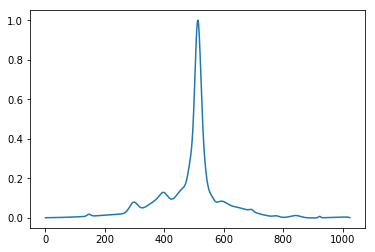

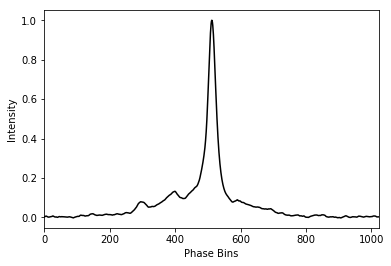

In [21]:
# Make the template
template_sp = observations[template_obs].getSinglePulses(windowsize=32)
template_sp.center_align()
template_sp.normalize()
template = template_sp.vonMises_smoothing(nmax=30)

# Check template
plt.close()
plt.plot(template)
template_sp.plot()
plt.show()

In [22]:
# Load second template.
old_template = pulsar.Archive('template_1024_A2.std.sm')
# Make the template
old_template.tscrunch()
old_template.fscrunch()
# Now get array of the best profile
old_data = old_template.getData()
# Obtain the single pulse (change windowsize)
old_template_sp = pulsar.SinglePulse(old_data, windowsize=256)
# Align and normalize
old_template_sp.center_align()
old_template_sp.normalize()

Loading: template_1024_A2.std.sm
Load time: 0.73 s


In [35]:
# Compare template
plt.close()

#plt.plot(template)

plt.plot(old_template_sp.getData() , label="Template A2 nbin=1024" )
plt.plot(template , label="Template A1 nbin=1024")

#plt.plot(sp_observations['./A1/prepfold_20190916_220850_PSR_2241-5236.fits'].getData(
#plt.show()
plt.title('Phase bins vs Intensity')
plt.xlabel('Phase Bins')
plt.ylabel('Intensity')
plt.legend(loc="upper right", fontsize='small')

plt.savefig('templates.png' , bbox_inches='tight' , dpi=400)